<h2>Bateman Equations for Multiple Decay</h2>

The inventory of each of four compounds was calculated assuming a multi-step reaction model. These calculations require several assumptions (Eganhouse and Pontolillo, 2008), as follows: (1) reactions and loss occur through first-order kinetics; (2) the only competing reaction is loss through unspecified physical processes discussed below; and (3) rates are constant over time and uniform throughout the sediment deposit (except the physical loss rate). The time-rate of change in $DDE$ inventory was determined by dechlorination to $DDMU$ and by possible losses through other processes. Likewise, the change in $DDMU$ inventory was determined losses from dechlorination to $DDNU$, gains from dechlorination of parent $DDE$, and losses by other processes. $DDNU$ inventory changes were analogous, with losses to an unspecified compound, gains from parent $DDMU$, and possible losses through other processes. The inventory of the final, unspecified product changes with gains from transformation of $DDMU$ and possible losses to other processes. The coupled differential equations (1) are

$\begin{matrix}
\frac{d{{C}_{DDE}}}{dt}=-{{\lambda }_{DDE\to DDMU}}{{C}_{DDE}}-{{\lambda }_{Loss}}{{C}_{DDE}}  \\
   \frac{d{{C}_{DDMU}}}{dt}=-{{\lambda }_{DDMU\to DDNS}}{{C}_{DDMU}}+{{\lambda }_{DDE\to DDMU}}{{C}_{DDE}}-{{\lambda }_{Loss}}{{C}_{DDMU}}  \\
   \frac{d{{C}_{DDNU}}}{dt}=-{{\lambda }_{DDNU\to ?}}{{C}_{DDNU}}+{{\lambda }_{DDMU\to DDNU}}{{C}_{DDMU}}-{{\lambda }_{Loss}}{{C}_{DDNU}}  \\
   \frac{d{{C}_{UN}}}{dt}={{\lambda }_{DDNU\to UN}}{{C}_{DDNU}}-{{\lambda }_{Loss}}{{C}_{UN}}  \\
\end{matrix}$

where the molar concentrations $C$ [$\mu$mol/kg dry sediment] of each compound and the transformation rate coefficients  [y-1] are labeled with subscripts. The losses to other processes accounted for physical removal of compounds from the sediment. Processes that have been suggested include direct desorption, resuspension and desorption, desorption into porewater and irrigation, and uptake by benthic deposit feeders. We have assumed that the combined rate coefficient for these processes applies equally to all four compounds. 


Import dependencies

In [1]:
from scipy.integrate import odeint
from pylab import *
from lmfit import *
%matplotlib inline

These data are from spreadsheet e-mailed to CRS from Bob Eganhouse 16-Dec-2016 'Inventories for C.Sherwood 12-16-2016.xlsx'

In [2]:
# Select on of the sites and load data
site = 'Site 3C'
#site = 'Site 6C'
if site == 'Site 3C':
    A=np.array([\
    [1981.27,1.34,0.07,0.004,0.0081,0.0062,0.0076],\
    [1992.51,0.71,0.25,0.012,0.0066,0.0049,0.0064],\
    [2003.58,0.39,0.32,0.036,0.0050,0.0037,0.0050],\
    [2009.23,0.38,0.52,0.069,0.0076,0.0076,0.0085],\
    [2010.31,0.41,0.52,0.085,0.0075,0.0072,0.0079]])
if site == 'Site 6C':
    print("no data yet")

t = A[:,0]
DDE=A[:,1]
DDMU=A[:,2]
DDNU=A[:,3]

print("Data from {0} with shape {1}".format(site,A.shape))
print('\n'.join([''.join(['{:5.4f}  '.format(item) for item in row]) 
      for row in A]))

Data from Site 3C with shape (5, 7)
1981.2700  1.3400  0.0700  0.0040  0.0081  0.0062  0.0076  
1992.5100  0.7100  0.2500  0.0120  0.0066  0.0049  0.0064  
2003.5800  0.3900  0.3200  0.0360  0.0050  0.0037  0.0050  
2009.2300  0.3800  0.5200  0.0690  0.0076  0.0076  0.0085  
2010.3100  0.4100  0.5200  0.0850  0.0075  0.0072  0.0079  


This cell is a stand-alone example of integrating the coupled ODEs

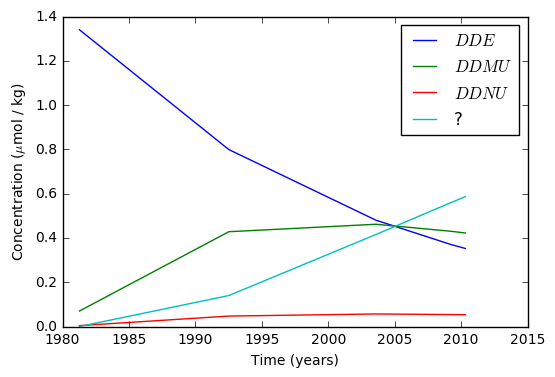

In [3]:
# In my previous notebook decay rates were global variables
# so they can be seen inside the function. That is not necessary
# if you use the args = (k,) syntax
k = np.array([.046, .056, .46, .0])

# define a function to represent coupled ordinary differential eqns.
# this version allows for a fourth loss term that applies to all compounds
def dcdt(c, t, k):
    dfdt = np.zeros(4)
    dfdt[0] = c[0]* -k[0] - c[0]*k[3]
    dfdt[1] = c[1]* -k[1] + c[0]*k[0] - c[1]*k[3] 
    dfdt[2] = c[2]* -k[2] + c[1]*k[1] - c[2]*k[3]
    dfdt[3] =               c[2]*k[2] - c[3]*k[3]
    return dfdt
    
# intial concentration for four constituents
C0 = np.array([1.34, .07, .004, 0.])

# time array
# t = linspace(0.0,100.,50)

# or, for discrete times that match measurements:
t = np.array(( 1981.27, 1992.51, 2003.58, 2009.23, 2010.31 ))

# Use the 
C = odeint(dcdt,C0,t, args = (k,))

fig = plt.figure()
plt.plot(t,C[:,0],label='$DDE$')
plt.plot(t,C[:,1],label='$DDMU$')
plt.plot(t,C[:,2],label='$DDNU$')
plt.plot(t,C[:,3],label='?')
plt.xlabel('Time (years)')
plt.ylabel('Concentration ($\mu$mol / kg)')
plt.legend(loc='upper right')

In [4]:
# Version of ODE with three-generation transformation and only three transfer terms
def dcdt3(c, t, k):
    dfdt = np.zeros(3)
    dfdt[0] = c[0]* -k[0]
    dfdt[1] = c[1]* -k[1] + c[0]*k[0]
    dfdt[2] = c[2]* -k[2] + c[1]*k[1]
    return dfdt

# Objective function to minimize, fit through origin, estimate decay rate
def residual(params, t, data, eps_data):
    C0 = data[0]
    k = params['decay_rate']
    model = C0*np.exp(-k*(t-t[0]))
    return (data-model)/eps_data

# Objective function to minimize, estimate origin and decay rate
def residual2(params, t, data, eps_data):
    C0 = params['init_conc']
    k = params['decay_rate']
    model = C0*np.exp(-k*(t-t[0]))
    return (data-model)/eps_data

# Objective function using ODE for three-generation transformation 
def residual3(params, t, data, eps_data):
    # Data is passed as a vector
    # Index on length of time array to find intitial concentrations
    nt = t.size
    k = np.array((params['k1'],params['k2'],params['k3']))
    C0 = np.array((data[0],data[nt],data[2*nt]))
    C = odeint(dcdt3,C0,t, args = (k,))
    model = np.concatenate((C[:,0],C[:,1],C[:,2]))
    return (data-model)/eps_data
    

In [5]:
adjust_inventories=True # Adjust using PCBs?
use_eps=True

# guess at std. error in measurements per conv. with R.E.
stde_DDE  = 0.05 #RE suggests 0.05
stde_DDMU = 0.05 #RE suggested 0.1
stde_DDNU = 0.05 #RE suggested 0.1
stde_PCB  = 0.05 # std. error of measurements is around 0.2
eps_DDE = stde_DDE*DDE  
eps_DDMU = stde_DDMU*DDMU #RE suggested 0.1
eps_DDNU = stde_DDNU*DDNU #RE suggested 0.2

# calculate adjustment according to mean of all PCBs inventory
adj = A[:,4:6].mean(axis=1)
adj = adj/adj.mean()
print("Normalized PCB inventories")
print(adj)
eps_adj = stde_PCB*adj
print("Std. deviation of normalized PCB inventories: {0:5.3f}\n".format(adj.std()))

# Data for DDE loss only
data = DDE
eps_data = ones_like(data)
if use_eps:
    eps_data = eps_DDE

print('DDE data: ')
print(data)
if use_eps:
    print('Using these uncertainties:')

print('eps_data: ')
print(eps_data)

# Adjust inventories according to PCB inventories?
if(adjust_inventories):
    data = data*adj
    eps_data = ones_like(data)
    if use_eps:
        eps_data = data.mean()*np.sqrt( (eps_data/data.mean())**2. + (eps_adj/adj.mean())**2. )
    
    print('Adjusted DDE data: ')
    print(data)
    print('Adjusted eps_data: ')
    print(eps_data)
    
#r = residual(params, t, data, eps_data)
#m = data[0]*np.exp(-params['decay_rate']*(t-t[0]))
#print("model: ",m)
#print("residuals: ",r)

print('\n\nEstimate decay rate with fit through origin')
params = Parameters()
# Note that this does not work if there are extra parameters
#params.add('init_conc',value = 1., min = 0., max= 5.)
params.add('decay_rate',value = 0.4, min =0., max = 1.)
out = minimize(residual, params, method='leastsq', args=(t,data,eps_data))
report_fit(out)

print('\n\nEstimate decay rate and initial conc')
params = Parameters()
params.add('init_conc',value = 1., min = 0., max= 5.)
params.add('decay_rate',value = 0.4, min =0., max = 1.)
out = minimize(residual2, params, method='leastsq', args=(t,data,eps_data))
report_fit(out)

Normalized PCB inventories
[ 1.11024845  0.89285714  0.67546584  1.18012422  1.14130435]
Std. deviation of normalized PCB inventories: 0.190

DDE data: 
[ 1.34  0.71  0.39  0.38  0.41]
Using these uncertainties:
eps_data: 
[ 0.067   0.0355  0.0195  0.019   0.0205]
Adjusted DDE data: 
[ 1.48773292  0.63392857  0.26343168  0.4484472   0.46793478]
Adjusted eps_data: 
[ 1.00067155  1.00043437  1.00024862  1.00075871  1.00070963]


Estimate decay rate with fit through origin
[[Fit Statistics]]
    # function evals   = 17
    # data points      = 5
    # variables        = 1
    chi-square         = 0.101
    reduced chi-square = 0.025
    Akaike info crit   = -17.504
    Bayesian info crit = -17.894
[[Variables]]
    decay_rate:   0.05700783 +/- 0.009128 (16.01%) (init= 0.4)
[[Correlations]] (unreported correlations are <  0.100)


Estimate decay rate and initial conc
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 5
    # variables        = 2
    chi-square         

In [7]:
# Put data for all compounds in a single vector
data = np.concatenate((DDE,DDMU,DDNU))
eps_data = np.concatenate((eps_DDE,eps_DDMU,eps_DDNU))
print('data')
print(data)
print('eps_data')
print(eps_data)
nt = t.size

if(adjust_inventories):
    data = data*adj
    eps_data = np.sqrt( (eps_data/data.mean())**2. + (eps_adj/adj.mean())**2. )


print('\n\nFull monty')
params = Parameters()
params.add('k1',value = 0.4, min =0., max = 1.)
params.add('k2',value = 0.4, min =0., max = 1.)
params.add('k3',value = 0.4, min =0., max = 1.)

# Test the ODE solver
k = np.array((params['k1'],params['k2'],params['k3']))
C0 = np.array((data[0],data[nt],data[2*nt]))
C = odeint(dcdt3,C0,t, args = (k,))
model = np.concatenate((C[:,0],C[:,1],C[:,2]))
print("model shape:", shape(model))
print(model)
print("data shape:", shape(data))
print(data)

# Test the objective function outside
res = residual3(params, t, data, eps_data)
print("residual3 shape:",shape(res))

# Optimize the parameters using least-squares fit
out = minimize(residual3, params, method='leastsq', args=(t,data,eps_data))
report_fit(out)

# Get the fitted rates
k1f=out.params['k1'].value
k2f=out.params['k2'].value
k3f=out.params['k3'].value
k1e = out.params['k1'].stderr
k2e = out.params['k2'].stderr
k3e = out.params['k3'].stderr
# Get fit metrics
chis = out.chisqr
chir = out.redchi

print(chis, chir)
print(k1f,k2f,k3f)
print(k1e)

data
[ 1.34   0.71   0.39   0.38   0.41   0.07   0.25   0.32   0.52   0.52
  0.004  0.012  0.036  0.069  0.085]
eps_data
[ 0.067    0.0355   0.0195   0.019    0.0205   0.0035   0.0125   0.016
  0.026    0.026    0.0002   0.0006   0.0018   0.00345  0.00425]


ValueError: operands could not be broadcast together with shapes (15,) (5,) 

Site3C.date = A(:,1);
Site3C.DDE = A(:,2);
Site3C.DDMU = A(:,3);
Site3C.DDNU = A(:,4);
Site3C.PCB118 = A(:,5);
Site3C.PCB153 = A(:,6);
Site3C.PCB138 = A(:,7);
Site3C.names = {{'sampling date (decimal year)'},...
  {'p,p''-DDE (mmol/cm2)'},...
  {'p,p''-DDMU (mmol/cm2)'},...
  {'p,p''-DDNU (mmol/cm2)'},...
  {'PCB 118 (mmol/cm2)'},...
  {'PCB 153 (mmol/cm2)'},...
  {'PCB 138 (mmol/cm2)'}}
Site3C.source = {'Data from spreadsheet e-mailed to CRS from Bob Eganhouse 16-Dec-2016 ''Inventories for C.Sherwood 12-16-2016.xlsx'''};